In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import statistics
import itertools
from sympy import symbols, solve, Eq

In [68]:
# Fungsi Plot Gambar di Jupiter
def plot_images(*imgs, figsize=(30,20), hide_ticks=False):
    f = plt.figure(figsize=figsize)
    width = np.ceil(np.sqrt(len(imgs)))
    height = np.ceil(len(imgs) / width)
    for i, img in enumerate(imgs, 1):
        ax = f.add_subplot(int(height), int(width), i)
        if hide_ticks:
            ax.axis('off')
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [69]:
# Fungsi Hamming Distance
def hamming_distance(vector1, vector2):
    # Pastikan kedua vektor memiliki panjang yang sama
    assert len(vector1) == len(vector2), "Panjang vektor harus sama"

    # Hitung Hamming distance
    distance = sum(bit1 != bit2 for bit1, bit2 in zip(vector1, vector2))
    
    return distance

In [70]:
def jarak(vector1, vector2):
    return ((vector1[0]-vector2[0])**2 + (vector1[1]-vector2[1])**2)**0.5

In [71]:
def angle_between_vectors(v1, v2):
    dot_product = np.dot(v1, v2)
    cross_product = np.cross(v1, v2)
    
    # Hitung sudut antara dua vektor
    angle = np.arctan2(np.linalg.norm(cross_product), dot_product)
    
    # Tentukan arahnya (clockwise atau counter-clockwise)
    direction = np.sign(cross_product)
    
    angle = np.degrees(angle)*direction
    return angle

In [72]:
def homography(pairs):
    rows = []
    for i in range(pairs.shape[0]):
        p1 = np.append(pairs[i][0:2], 1)
        p2 = np.append(pairs[i][2:4], 1)
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        rows.append(row1)
        rows.append(row2)
    rows = np.array(rows)
    U, s, V = np.linalg.svd(rows)
    H = V[-1].reshape(3, 3)
    H = H/H[2, 2] # standardize to let w*H[2,2] = 1
    return H

In [73]:
def random_point(matches, k=4):
    idx = random.sample(range(len(matches)), k)
    point = [matches[i] for i in idx ]
    return np.array(point)

In [74]:
def get_error(points, H):
    num_points = len(points)
    all_p1 = np.concatenate((points[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = points[:, 2:4]
    estimate_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        temp = np.dot(H, all_p1[i])
        estimate_p2[i] = (temp/temp[2])[0:2] # set index 2 to 1 and slice the index 0, 1
    # Compute error
    errors = np.linalg.norm(all_p2 - estimate_p2 , axis=1) ** 2

    return errors

In [76]:
def ransac(matches, threshold, iters):
    num_best_inliers = 0
    
    for i in range(iters):
        points = random_point(matches)
        H = homography(points)
        
        #  avoid dividing by zero 
        if np.linalg.matrix_rank(H) < 3:
            continue
            
        errors = get_error(matches, H)
        idx = np.where(errors < threshold)[0]
        inliers = matches[idx]

        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            best_H = H.copy()
           
    print("inliers/matches: {}/{}".format(num_best_inliers, len(matches)))
    return best_inliers, best_H

In [ ]:
# ********* Insert Image *********
image_paths = glob.glob('AmbilDataCahayaFull1_1/*.jpg')
imgs = []
n = len(image_paths)
# n = 5

# ********* Kernel Pre-Processing *********
kernel_contras = np.array([[-1, -1, -1],
                [-1, 9, -1],
                [-1, -1, -1]])
kernel_sharp = np.array([[0, -1, 0],
                [-1, 5, -1],
                [0, -1, 0]])

# ********* Matriks Kalibrasi Kamera *********
mtx1 = np.array([[682.84055098,   0.,         308.47833431],
 [  0.,         683.17356074, 184.14295734],
 [  0.,           0.,           1.        ]])
dist1 = np.array([-0.02243873,  0.10428033, -0.00261665, -0.00163101, -0.19535318])
newcameramtx1 = np.array([[680.79500661,   0.,         307.68874874],
 [  0.,         681.03835398, 183.55170193],
 [  0.,           0.,           1.        ]])
roi1 = [1, 1, 638, 278]

# ********* Save Image in Var *********
for i in range(n):
    img = cv2.imread(image_paths[i])
    # # Resizing
    # if i == 0:
    #     img = cv2.resize(img,None,fx=280/271,fy=280/271)
    # # Calibrating
    # img = cv2.undistort(img, mtx1, dist1, None, newcameramtx1)
    # x, y, w, h = roi1
    # img = img[y:y+h, x:x+w]
    # # Rotating
    # img = cv2.rotate(img, cv2.ROTATE_180)

    imgs.append(img)

# ********* Pre-Processing Left *********
pref = imgs[0]
pref_gray = cv2.cvtColor(pref, cv2.COLOR_BGR2GRAY)
pref_pp = cv2.convertScaleAbs(pref_gray, alpha=1.5, beta=7)
# pref_pp = cv2.filter2D(pref_pp, -1, kernel_sharp)

# # ********* Menyamakan Intensitas *********
# if pref_pp.any() < 80:
#     for k in range(pref_pp.shape[0]):
#         for l in range(pref_pp.shape[1]):
#             if pref_pp[k,l] < 80:
#                 pref_pp[k,l] = random.randint(80, 100)

# ********* Deklarasi Metode *********
orb = cv2.ORB_create(nfeatures=500, scaleFactor=1.2, nlevels=5, edgeThreshold=10, firstLevel=0, WTA_K=2, scoreType=1, patchSize=50, fastThreshold=20)

# ********* Mask *********
mask_top_left = np.zeros_like(pref_gray, dtype=np.uint8)
mask_top_left[:pref_gray.shape[0]//2+20, :pref_gray.shape[1]//2+20] = 255

mask_top_right = np.zeros_like(pref_gray, dtype=np.uint8)
mask_top_right[:pref_gray.shape[0]//2+20, pref_gray.shape[1]//2-20:] = 255

mask_bottom_left = np.zeros_like(pref_gray, dtype=np.uint8)
mask_bottom_left[pref_gray.shape[0]//2-20:, :pref_gray.shape[1]//2+20] = 255

mask_bottom_right = np.zeros_like(pref_gray, dtype=np.uint8)
mask_bottom_right[pref_gray.shape[0]//2-20:, pref_gray.shape[1]//2-20:] = 255

# ********* Ekstraksi Fitur *********
kp_pref_tl, des_pref_tl = orb.detectAndCompute(pref_pp, mask_top_left)
kp_pref_tr, des_pref_tr = orb.detectAndCompute(pref_pp, mask_top_right)
kp_pref_bl, des_pref_bl = orb.detectAndCompute(pref_pp, mask_bottom_left)
kp_pref_br, des_pref_br = orb.detectAndCompute(pref_pp, mask_bottom_right)

kp_pref = kp_pref_tl + kp_pref_tr + kp_pref_bl + kp_pref_br
des_pref = np.vstack((des_pref_tl, des_pref_tr, des_pref_bl, des_pref_br))

# ********* Buang Fitur Berdempetan *********
kp_p_f = []
des_p_f = []
responses = []
for idx1, kp in enumerate(kp_pref):
    x, y = kp.pt
    idx2 = -1
    for idx2 in range(len(kp_p_f)):
        if jarak((x,y), kp_p_f[idx2]) < 4: # Adjustable
            if responses[idx2] < kp.response:
                des_p_f[idx2] = des_pref[idx1,:]
                kp_p_f[idx2] = (x,y)
                responses[idx2] = kp.response
            idx2 -= 1
            break
    if idx2 == len(kp_p_f)-1:
        des_p_f.append(des_pref[idx1,:])
        kp_p_f.append((x,y))
        responses.append(kp.response)
des_p_f = np.array(des_p_f)
kp_p_f = np.array(kp_p_f).astype(int)

# ********* Matriks Transformasi *********
TM = []

# ********* Loop Feature Detection - Get Transformation Matrix *********
for i in range(1,n):
    left = pref
    left_gray = pref_gray
    left_pp = pref_pp

    kp_left = kp_pref
    des_left = des_pref
    des_l_f = des_p_f
    kp_l_f = kp_p_f

    # ********* Pre-Processing Right *********
    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    right_pp = cv2.convertScaleAbs(right_gray, alpha=1.5, beta=7)
    # right_pp = cv2.filter2D(right_pp, -1, kernel_sharp)

    # # ********* Menyamakan Intensitas *********
    # if right_pp.any() < 80:
    #     for k in range(right_pp.shape[0]):
    #         for l in range(right_pp.shape[1]):
    #             if right_pp[k,l] < 80:
    #                 right_pp[k,l] = random.randint(80, 100)


    # ********* Ekstraksi Fitur *********
    kp_right_tl, des_right_tl = orb.detectAndCompute(right_pp, mask_top_left)
    kp_right_tr, des_right_tr = orb.detectAndCompute(right_pp, mask_top_right)
    kp_right_bl, des_right_bl = orb.detectAndCompute(right_pp, mask_bottom_left)
    kp_right_br, des_right_br = orb.detectAndCompute(right_pp, mask_bottom_right)

    kp_right = ()
    des_right = np.array([])
    for var in [kp_right_tl, kp_right_tr, kp_right_bl, kp_right_br]:
        if var:
            kp_right += var
    for var in [des_right_tl, des_right_tr, des_right_bl, des_right_br]:
        if var is not None:
            if des_right.size == 0:
                des_right = var
            else:
                des_right = np.vstack((des_right, var))

    # # ********* Gambar KeyPoint *********
    # keypoints_drawn_left = cv2.drawKeypoints(left, kp_left, None, color=(0, 255, 0))
    # keypoints_drawn_right = cv2.drawKeypoints(right, kp_right, None, color=(0, 255, 0))
    # plot_images(keypoints_drawn_left, keypoints_drawn_right)

    # ********* Buang Fitur Berdempetan *********
    kp_r_f = []
    des_r_f = []
    responses = []
    for idx1, kp in enumerate(kp_right):
        x, y = kp.pt
        idx2 = -1
        for idx2 in range(len(kp_r_f)):
            if jarak((x,y), kp_r_f[idx2]) < 4: # Adjustable
                if responses[idx2] < kp.response:
                    des_r_f[idx2] = des_right[idx1,:]
                    kp_r_f[idx2] = (x, y)
                    responses[idx2] = kp.response
                idx2 -= 1
                break
        if idx2 == len(kp_r_f)-1:
            des_r_f.append(des_right[idx1,:])
            kp_r_f.append((x, y))
            responses.append(kp.response)
    des_r_f = np.array(des_r_f)
    kp_r_f = np.array(kp_r_f).astype(int)
    
    # # ********* Gambar Filtered KeyPoint *********
    # left_draw_kp = pref.copy()
    # right_draw_kp = imgs[i].copy()
    # for point in kp_l_f:
    #     cv2.circle(left_draw_kp, point, 4, (0,255,0))
    # for point in kp_r_f:
    #     cv2.circle(right_draw_kp, point, 4, (0,255,0))
    # # lr_draw_kp = cv2.addWeighted(left_draw_kp, 0.5, right_draw_kp, 0.5, 0)
    # plot_images(left_draw_kp,right_draw_kp)
    # # plot_images(left_pp)

    # ********* Pencocokan Fitur MN *********
    pt_mat = []
    dis_mat = []
    for idx1 in range(len(kp_l_f)):
        # xl, yl = kp_l_f[idx1]
        d_best = float('inf')
        for idx2 in range(len(kp_r_f)):
            # xr, yr = kp_r_f[idx2]
            # if jarak((xr,yr),(xl,yl)) < 80:
            d = hamming_distance(des_l_f[idx1], des_r_f[idx2])
            if d < d_best:
                d_best = d
                idx = idx2
        if d_best < 31:
            pt_mat.append((kp_l_f[idx1][0],kp_l_f[idx1][1],kp_r_f[idx][0],kp_r_f[idx][1]))
            dis_mat.append(d_best)
            
    # # ********* Gambar Matches & Hitung Jarak ********* 
    # for k in range(len(pt_mat)):
    #     img_con = np.concatenate((left, right), axis=1)
    #     for x1, y1, x2, y2 in pt_mat[k:k+1]:
    #         cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #         cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    #         cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    #     plot_images(img_con)

    # img_con = np.concatenate((left, right), axis=1)
    # dis_pos = []
    # for x1, y1, x2, y2 in pt_mat:
    #     dis_pos.append(jarak((x1,y1), (x2,y2)))
    #     cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con)
    # print(dis_mat)
    # print(dis_pos)

    # # ********* Miss Match Removing - Berdasarkan Jarak *********
    # rounded_dis_pos = [round(num, -1) for num in dis_pos]
    # modus = statistics.mode(rounded_dis_pos)
    # pt_mat_df = []
    # dis_mat_df = []
    # for k in range(len(pt_mat)):
    #     if rounded_dis_pos[k] == modus:
    #         pt_mat_df.append(pt_mat[k])
    #         dis_mat_df.append(dis_mat[k])
    # if len(pt_mat_df) < 2:
    #     pt_mat_df = pt_mat
    #     dis_mat_df = dis_mat
    # # print(pt_mat_df)
    # # print(dis_mat_df)

    # ********* Miss Match Removing - Berdasarkan Hamming Distance *********
    sorted_combined = sorted(zip(dis_mat, pt_mat))
    limit = 8
    sorted_dis, sorted_pt = zip(*sorted_combined[:limit])

    # # ********* Gambar Best Matches *********
    # img_con = np.ones((min(left.shape[0], right.shape[0]),left.shape[1] + right.shape[1],3), dtype="uint8")
    # img_con[0:img_con.shape[0],0:left.shape[1]] = left[0:img_con.shape[0],0:left.shape[1]]
    # img_con[0:img_con.shape[0],left.shape[1]:img_con.shape[1]] = right[0:img_con.shape[0],0:right.shape[1]]
    # for x1, y1, x2, y2 in sorted_pt:
    #     cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con)

    # ********* Cari Matriks Transformasi Terbaik *********
    kombinasi = list(itertools.combinations(sorted_pt, 2))
    Merr = float('inf')
    for k in range(len(kombinasi)):
        x1, y1, x2, y2 = kombinasi[k][0]
        x3, y3, x4, y4 = kombinasi[k][1]
        # Translasi
        tx = (x1 - x2)
        ty = (y1 - y2)
        T1 = np.array([[1, 0, tx],
                [0, 1, ty],
                [0, 0, 1]])
        # Rotasi
        v1 = (x3-x1, y3-y1)
        v2 = (x4-x2, y4-y2)
        theta, direction = angle_between_vectors(v1, v2) 
        theta = theta*direction
        # perbesaran = np.linalg.norm(v1)/np.linalg.norm(v2)
        perbesaran = 1
        T2 = cv2.getRotationMatrix2D((float(x2+tx),float(y2+ty)), theta, perbesaran)
        MT = np.dot(T2,T1)
        # Error
        err = 0
        for xx1, yy1, xx2, yy2 in sorted_pt:
            xx3, yy3 = np.dot(MT,[xx2,yy2,1])
            # xx4, yy4 = np.dot(np.linalg.inv(MT), [xx1,yy1,1])
            err += jarak((xx1,yy1),(xx3,yy3)) 
        if err < Merr:
            Merr = err
            M = MT

    # Simpan Matriks Transformasi
    if i == 1:
        TM.append(M)
        TM = np.array(TM)
    else:
        M1 = np.vstack((TM[i-2], [0, 0, 1]))
        M = np.dot(M1,M)
        TM = np.append(TM, [M], axis=0)

    # Simpan Gambar Kanan Untuk Kiri
    pref = right
    pref_gray = right_gray
    pref_pp = right_pp

    kp_pref = kp_right
    des_pref = des_right
    des_p_f = des_r_f
    kp_p_f = kp_r_f

# ********* Loop Image Fussion *********
pref = imgs[0]
for i in range(1,n):
    left = pref
    left_gray = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    right_pp = cv2.convertScaleAbs(right_gray, alpha=1.5, beta=7)
    # ********* Menyamakan Intensitas *********
    if right_pp.any() < 80:
        for k in range(right_pp.shape[0]):
            for l in range(right_pp.shape[1]):
                if right_pp[k,l] < 80:
                    right_pp[k,l] = random.randint(80, 100)
    
    dim_x = left.shape[1] + right.shape[1]
    dim_y = left.shape[0] + right.shape[0]
    dim = (dim_x, dim_y)
    comb = cv2.warpAffine(right,TM[i-1],dim)
    comb_pp = cv2.warpAffine(right_pp,TM[i-1],dim)
    # plot_images(comb)

    # ********* Membuat Mask *********
    _, th = cv2.threshold(comb_pp, 1, 255, cv2.THRESH_BINARY)
    kernel = np.ones((45, 45), np.uint8)
    mask = cv2.erode(th, kernel, iterations=1)
    mask = cv2.GaussianBlur(mask, (25, 25), 0)
    # plot_images(mask)

    # ********* Jahit Citra *********
    for k in range(left.shape[0]):
        for l in range(left.shape[1]):
            alpha = mask[k,l]/255
            comb[k,l] = (1-alpha)*left[k,l] + alpha*comb[k,l]
            # if mask[k,l] == 0:
            #     comb[k,l] = left[k,l]
            # else:
            #     alpha_k = (left.shape[0]-k)/(left.shape[0])
            #     alpha_l = (left.shape[1]-l)/(left.shape[1])
            #     alpha = max(alpha_k,alpha_l)
            #     comb[k,l] = alpha*left[k,l] + (1-alpha)*comb[k,l]
    # ********* Crop *********
    comb_gray = cv2.cvtColor(comb, cv2.COLOR_BGR2GRAY)
    for j in range(int(dim_x/2),dim_x):
        if comb_gray[:,j].sum() == 0:
            x_crop = j
            break
        else:
            x_crop = dim_x
    for j in range(int(dim_y/2),dim_y):
        if comb_gray[j,:].sum() == 0:
            y_crop = j
            break
        else:
            y_crop = dim_y
    if y_crop == dim_y | x_crop == dim_x:
        print("Penjahitan Error!")
        break
    pref = comb[:y_crop, :x_crop]
plot_images(pref)


In [ ]:
cv2.imwrite('HasilAmbilDataGabungan.jpg',pref)

inliers/matches: 28/234
1: 0.0
inliers/matches: 23/217
2: 0.0
inliers/matches: 32/206
3: 0.0
inliers/matches: 20/248
4: 2.0
inliers/matches: 21/237
5: 0.0
inliers/matches: 19/236
6: 0.45066176577944406
inliers/matches: 19/239
7: 4.0
inliers/matches: 24/218
8: 5.365018052521374
inliers/matches: 35/191
9: 0.0
inliers/matches: 24/207
10: 0.0
inliers/matches: 37/175
11: 0.0
inliers/matches: 21/185
12: 0.0
inliers/matches: 37/187
13: 0.0
inliers/matches: 40/188
14: 0.0
inliers/matches: 25/195
15: 0.0
inliers/matches: 31/216
16: 0.0
inliers/matches: 23/210
17: 0.0
inliers/matches: 26/180
18: 0.0
inliers/matches: 25/184
19: 2.0
inliers/matches: 25/181
20: 2.0
inliers/matches: 19/172
21: 0.0
inliers/matches: 32/184
22: 0.0
inliers/matches: 22/171
23: 0.0
inliers/matches: 24/170
24: 0.0
inliers/matches: 28/184
25: 1.479600757109926
inliers/matches: 28/171
26: 0.0
inliers/matches: 12/159
27: 4.0
inliers/matches: 14/206
28: 2.0
inliers/matches: 19/185
29: 0.0
inliers/matches: 23/158
30: 0.0
inlie

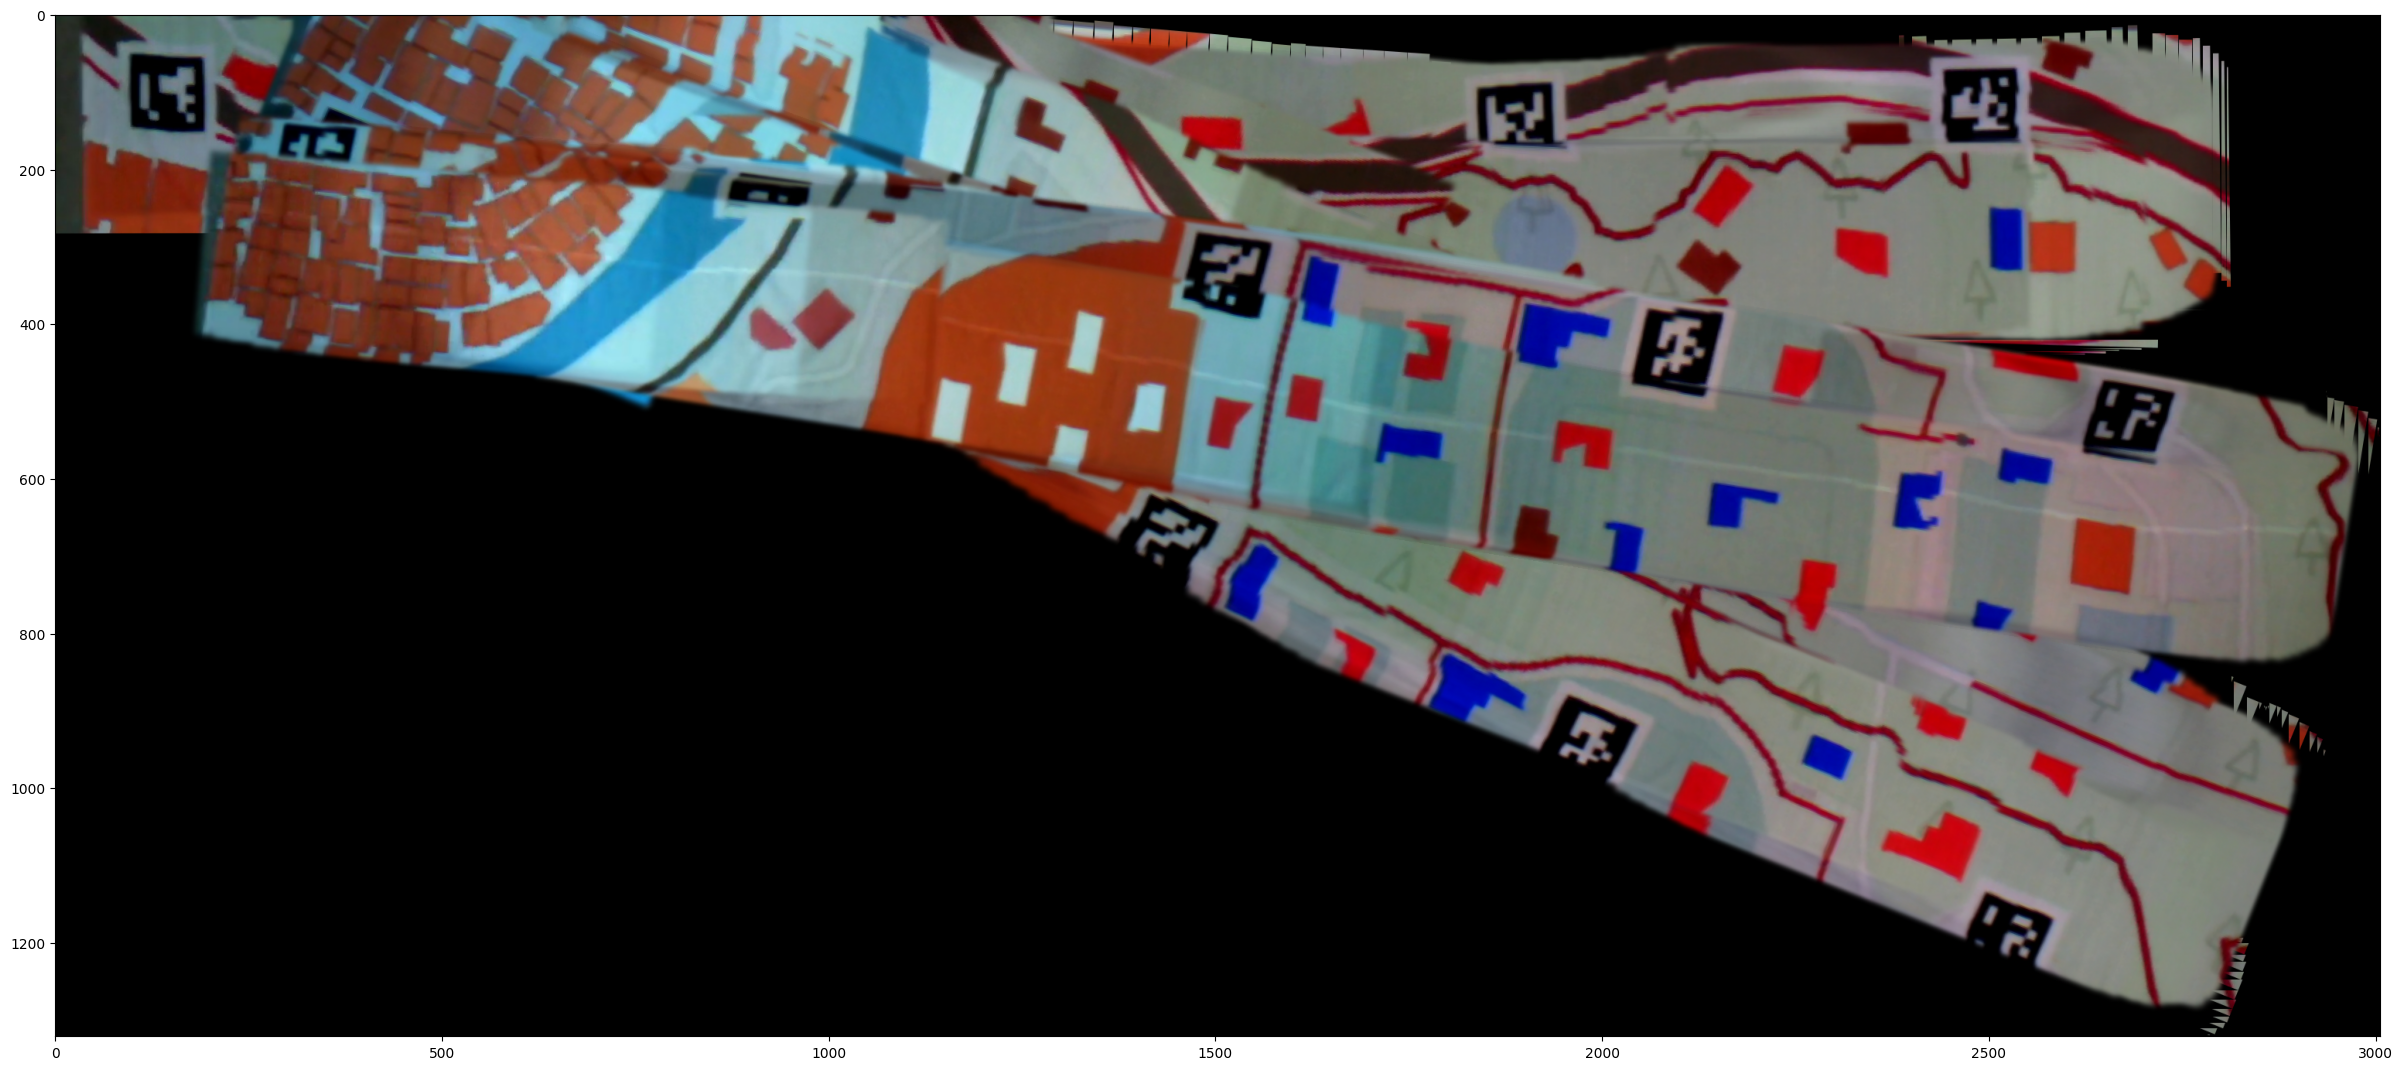

In [79]:
# ********* Versi 2 *********
# ********* Insert Image *********
image_paths = glob.glob('AmbilDataCahayaFull01/*.jpg')
imgs = []
n = len(image_paths)
# n = 78

# ********* Kernel Pre-Processing *********
kernel_contras = np.array([[-1, -1, -1],
                [-1, 9, -1],
                [-1, -1, -1]])
kernel_sharp = np.array([[0, -1, 0],
                [-1, 5, -1],
                [0, -1, 0]])

# ********* Matriks Kalibrasi Kamera *********
mtx1 = np.array([[682.84055098,   0.,         308.47833431],
 [  0.,         683.17356074, 184.14295734],
 [  0.,           0.,           1.        ]])
dist1 = np.array([-0.02243873,  0.10428033, -0.00261665, -0.00163101, -0.19535318])
newcameramtx1 = np.array([[680.79500661,   0.,         307.68874874],
 [  0.,         681.03835398, 183.55170193],
 [  0.,           0.,           1.        ]])
roi1 = [1, 1, 638, 284]

# ********* Save Image in Var *********
for i in range(n):
    img = cv2.imread(image_paths[i])
    # Calibrating
    img = cv2.undistort(img, mtx1, dist1, None, newcameramtx1)
    x, y, w, h = roi1
    img = img[y:y+h, x:x+w]
    # # Rotating
    # img = cv2.rotate(img, cv2.ROTATE_180)

    imgs.append(img)

# ********* Pre-Processing Left *********
pref = imgs[0]
pref_gray = cv2.cvtColor(pref, cv2.COLOR_BGR2GRAY)
pref_pp = cv2.convertScaleAbs(pref_gray, alpha=1.5, beta=7)

# ********* Deklarasi Metode *********
orb = cv2.ORB_create(nfeatures=500, scaleFactor=1.2, nlevels=5, edgeThreshold=10, firstLevel=0, WTA_K=2, scoreType=1, patchSize=51, fastThreshold=20)

# ********* Mask *********
mask_top_left = np.zeros_like(pref_gray, dtype=np.uint8)
mask_top_left[:pref_gray.shape[0]//2+20, :pref_gray.shape[1]//2+20] = 255

mask_top_right = np.zeros_like(pref_gray, dtype=np.uint8)
mask_top_right[:pref_gray.shape[0]//2+20, pref_gray.shape[1]//2-20:] = 255

mask_bottom_left = np.zeros_like(pref_gray, dtype=np.uint8)
mask_bottom_left[pref_gray.shape[0]//2-20:, :pref_gray.shape[1]//2+20] = 255

mask_bottom_right = np.zeros_like(pref_gray, dtype=np.uint8)
mask_bottom_right[pref_gray.shape[0]//2-20:, pref_gray.shape[1]//2-20:] = 255

# ********* Ekstraksi Fitur *********
kp_pref_tl, des_pref_tl = orb.detectAndCompute(pref_pp, mask_top_left)
kp_pref_tr, des_pref_tr = orb.detectAndCompute(pref_pp, mask_top_right)
kp_pref_bl, des_pref_bl = orb.detectAndCompute(pref_pp, mask_bottom_left)
kp_pref_br, des_pref_br = orb.detectAndCompute(pref_pp, mask_bottom_right)

kp_pref = kp_pref_tl + kp_pref_tr + kp_pref_bl + kp_pref_br
des_pref = np.vstack((des_pref_tl, des_pref_tr, des_pref_bl, des_pref_br))

# ********* Buang Fitur Berdempetan *********
kp_p_f = []
des_p_f = []
responses = []
for idx1, kp in enumerate(kp_pref):
    x, y = kp.pt
    idx2 = -1
    for idx2 in range(len(kp_p_f)):
        if jarak((x,y), kp_p_f[idx2]) < 4: # Adjustable
            if responses[idx2] < kp.response:
                des_p_f[idx2] = des_pref[idx1,:]
                kp_p_f[idx2] = (x,y)
                responses[idx2] = kp.response
            idx2 -= 1
            break
    if idx2 == len(kp_p_f)-1:
        des_p_f.append(des_pref[idx1,:])
        kp_p_f.append((x,y))
        responses.append(kp.response)
des_p_f = np.array(des_p_f)
kp_p_f = np.array(kp_p_f).astype(int)

# ********* Matriks Transformasi *********
TM = []

# ********* Loop Feature Detection - Get Transformation Matrix *********
for i in range(1,n):
    left = pref
    left_gray = pref_gray
    left_pp = pref_pp

    kp_left = kp_pref
    des_left = des_pref
    des_l_f = des_p_f
    kp_l_f = kp_p_f

    # ********* Pre-Processing Right *********
    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    right_pp = cv2.convertScaleAbs(right_gray, alpha=1.5, beta=7)

    # ********* Ekstraksi Fitur *********
    kp_right_tl, des_right_tl = orb.detectAndCompute(right_pp, mask_top_left)
    kp_right_tr, des_right_tr = orb.detectAndCompute(right_pp, mask_top_right)
    kp_right_bl, des_right_bl = orb.detectAndCompute(right_pp, mask_bottom_left)
    kp_right_br, des_right_br = orb.detectAndCompute(right_pp, mask_bottom_right)

    kp_right = ()
    des_right = np.array([])
    for var in [kp_right_tl, kp_right_tr, kp_right_bl, kp_right_br]:
        if var:
            kp_right += var
    for var in [des_right_tl, des_right_tr, des_right_bl, des_right_br]:
        if var is not None:
            if des_right.size == 0:
                des_right = var
            else:
                des_right = np.vstack((des_right, var))

    # # ********* Gambar KeyPoint *********
    # keypoints_drawn_left = cv2.drawKeypoints(left, kp_left, None, color=(0, 255, 0))
    # keypoints_drawn_right = cv2.drawKeypoints(right, kp_right, None, color=(0, 255, 0))
    # plot_images(keypoints_drawn_left, keypoints_drawn_right)

    # ********* Buang Fitur Berdempetan *********
    kp_r_f = []
    des_r_f = []
    responses = []
    for idx1, kp in enumerate(kp_right):
        x, y = kp.pt
        idx2 = -1
        for idx2 in range(len(kp_r_f)):
            if jarak((x,y), kp_r_f[idx2]) < 4: # Adjustable
                if responses[idx2] < kp.response:
                    des_r_f[idx2] = des_right[idx1,:]
                    kp_r_f[idx2] = (x, y)
                    responses[idx2] = kp.response
                idx2 -= 1
                break
        if idx2 == len(kp_r_f)-1:
            des_r_f.append(des_right[idx1,:])
            kp_r_f.append((x, y))
            responses.append(kp.response)
    des_r_f = np.array(des_r_f)
    kp_r_f = np.array(kp_r_f).astype(int)
    
    # # ********* Gambar Filtered KeyPoint *********
    # left_draw_kp = pref.copy()
    # right_draw_kp = imgs[i].copy()
    # for point in kp_l_f:
    #     cv2.circle(left_draw_kp, point, 4, (0,255,0))
    # for point in kp_r_f:
    #     cv2.circle(right_draw_kp, point, 4, (0,255,0))
    # # lr_draw_kp = cv2.addWeighted(left_draw_kp, 0.5, right_draw_kp, 0.5, 0)
    # plot_images(left_draw_kp,right_draw_kp)
    # # plot_images(left_pp)

    # ********* Pencocokan Fitur MN *********
    pt_mat = []
    for idx1 in range(len(kp_l_f)):
        d_best = float('inf')
        for idx2 in range(len(kp_r_f)):
            d = hamming_distance(des_l_f[idx1], des_r_f[idx2])
            if d < d_best:
                d_best = d
                idx = idx2
        pt_mat.append((kp_l_f[idx1][0],kp_l_f[idx1][1],kp_r_f[idx][0],kp_r_f[idx][1]))
    pt_mat = np.array(pt_mat)

    # # ********* Gambar Matches *********
    # img_con = np.concatenate((left, right), axis=1)
    # for x1, y1, x2, y2 in pt_mat:
    #     cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con)

    # ********* Miss Match Removing - RANSAC *********
    # while(True):
    #     idx = random.sample(range(len(pt_mat)), 3)
    #     point = [pt_mat[i] for i in idx]
    #     x1, y1, x2, y2 = point[0]
    #     x3, y3, x4, y4 = point[1]
    #     x5, y5, x6, y6 = point[2]
    #     a, b, c, d, e, f = symbols('a b c d e f')
    #     eq1 = Eq(x2*a + y2*b + c , x1)
    #     eq2 = Eq(x4*a + y4*b + c , x3)
    #     eq3 = Eq(x6*a + y6*b + c , x5)
    #     eq4 = Eq(x2*d + y2*e + f , y1)
    #     eq5 = Eq(x4*d + y4*e + f , y3)
    #     eq6 = Eq(x6*d + y6*e + f , y5)

    #     # Selesaikan sistem persamaan
    #     sol = solve((eq1, eq2, eq3, eq4, eq5, eq6), (a, b, c, d, e, f))
        
    #     if not isinstance(sol, dict) or len(sol) < 6:
    #         continue

    #     a1 = np.float64(sol[a])
    #     b1 = np.float64(sol[b])
    #     c1 = np.float64(sol[c])
    #     d1 = np.float64(sol[d])
    #     e1 = np.float64(sol[e])
    #     f1 = np.float64(sol[f])

    #     H = [[a1, b1, c1],
    #          [d1, e1, f1],
    #          [0, 0, 1]]

    #     # Error
    #     inliers = []
    #     for k in range(len(pt_mat)):
    #         xx1, yy1, xx2, yy2 = pt_mat[k]
    #         xx3, yy3, _ = np.dot(H,[xx2,yy2,1])
    #         err = jarak((xx1,yy1),(xx3,yy3))
    #         if err < 1:
    #             inliers.append(pt_mat[k]) 

    #     num_inliers = len(inliers)
    #     if num_inliers > 10:
    #         best_inliers = inliers.copy()
    #         M = H.copy()
    #         break
    # print("inliers/matches: {}/{}".format(num_inliers, len(pt_mat)))

    # # ********* Gambar Best Matches *********
    # img_con = np.ones((min(left.shape[0], right.shape[0]),left.shape[1] + right.shape[1],3), dtype="uint8")
    # img_con[0:img_con.shape[0],0:left.shape[1]] = left[0:img_con.shape[0],0:left.shape[1]]
    # img_con[0:img_con.shape[0],left.shape[1]:img_con.shape[1]] = right[0:img_con.shape[0],0:right.shape[1]]
    # for x1, y1, x2, y2 in best_inliers:
    #     cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con)

    # ********* Cari Matriks Transformasi Terbaik *********
    while(True):
        best_inliers,_ = ransac(pt_mat, 1, 2000)
        best_inliers = list(best_inliers)
        kombinasi = list(itertools.combinations(best_inliers, 2))
        Merr = float('inf')
        for k in range(len(kombinasi)):
            x1, y1, x2, y2 = kombinasi[k][0]
            x3, y3, x4, y4 = kombinasi[k][1]

            # Translasi
            tx = (x1 - x2)
            ty = (y1 - y2)
            T = np.array([
                [1, 0, tx],
                [0, 1, ty],
                [0, 0, 1]
            ])

            # Rotasi
            v1 = (x3-x1, y3-y1)
            v2 = (x4-x2, y4-y2)
            theta = angle_between_vectors(v1, v2)
            # Matriks translasi ke asal
            Tc1 = np.array([
                [1, 0, -x1],
                [0, 1, -y1],
                [0, 0, 1]
            ])
            # Matriks rotasi di sekitar asal
            R = np.array([
                [np.cos(theta), -np.sin(theta), 0],
                [np.sin(theta), np.cos(theta), 0],
                [0, 0, 1]
            ])
            # Matriks translasi kembali ke posisi awal
            Tc2 = np.array([
                [1, 0, x1],
                [0, 1, y1],
                [0, 0, 1]
            ])

            # # Perbesaran
            # dx1 = x3-x1
            # dx2 = x4-x2
            # dy1 = y3-y1
            # dy2 = y4-y2
            # if dx1 == 0 or dx2 == 0:
            #     sx = 1
            # else:
            #     sx = dx1/dx2
            # if dy1 == 0 or dy2 == 0:
            #     sy = 1
            # else:
            #     sy = dy1/dy2

            # # Matriks scaling di sekitar asal
            # S = np.array([
            #     [sx, 0, 0],
            #     [0, sy, 0],
            #     [0, 0, 1]
            # ])

            # Kombinasikan matriks transformasi
            H = T.copy() @ Tc2.copy() @ R.copy() @ Tc1.copy()

            # Error
            for xx1, yy1, xx2, yy2 in best_inliers:
                xe1, ye1,_ = H.copy() @ [xx2,yy2,1]
                Hinv = np.linalg.inv(H.copy())
                xe2, ye2,_ = Hinv.copy() @ [xx1,yy1,1]
                err = (xx1 - xe1)**2 + (yy1 - ye1)**2 + (xx2 - xe2)**2 + (yy2 - ye2)**2

            # Evaluasi
            if err < Merr:
                Merr = err
                M = H.copy()
            if Merr < 1:
                break
        print(str(i)+": "+str(Merr))
        if Merr < 20:
            break

    # Simpan Matriks Transformasi
    if i == 1:
        TM.append(M)
        TM = np.array(TM)
    else:
        Mbaru = TM[i-2] @ M.copy()
        TM = np.append(TM, [Mbaru], axis=0)

    # Simpan Gambar Kanan Untuk Kiri
    pref = right
    pref_gray = right_gray
    pref_pp = right_pp

    kp_pref = kp_right
    des_pref = des_right
    des_p_f = des_r_f
    kp_p_f = kp_r_f
    
# ********* Loop Image Fussion *********
pref = imgs[0]
for i in range(1,n):
    left = pref
    left_gray = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    right_pp = cv2.convertScaleAbs(right_gray, alpha=1.5, beta=7)
    # ********* Menyamakan Intensitas *********
    if right_pp.any() < 80:
        for k in range(right_pp.shape[0]):
            for l in range(right_pp.shape[1]):
                if right_pp[k,l] < 80:
                    right_pp[k,l] = random.randint(80, 100)
    
    dim_x = left.shape[1] + right.shape[1]
    dim_y = left.shape[0] + right.shape[0]
    dim = (dim_x, dim_y)
    comb = cv2.warpPerspective(right,TM[i-1],dim)
    comb_pp = cv2.warpPerspective(right_pp,TM[i-1],dim)

    # ********* Membuat Mask *********
    _, th = cv2.threshold(comb_pp, 1, 255, cv2.THRESH_BINARY)
    kernel = np.ones((45, 45), np.uint8)
    mask = cv2.erode(th, kernel, iterations=1)
    mask = cv2.GaussianBlur(mask, (25, 25), 0)

    # ********* Jahit Citra *********
    for k in range(left.shape[0]):
        for l in range(left.shape[1]):
            alpha = mask[k,l]/255
            comb[k,l] = (1-alpha)*left[k,l] + alpha*comb[k,l]

    # ********* Crop *********
    comb_gray = cv2.cvtColor(comb, cv2.COLOR_BGR2GRAY)
    for j in range(int(dim_x/2),dim_x):
        if comb_gray[:,j].sum() == 0:
            x_crop = j
            break
        else:
            x_crop = dim_x
    for j in range(int(dim_y/2),dim_y):
        if comb_gray[j,:].sum() == 0:
            y_crop = j
            break
        else:
            y_crop = dim_y
    if y_crop == dim_y | x_crop == dim_x:
        print("Penjahitan Error!")
        break
    pref = comb[:y_crop, :x_crop]
plot_images(pref)

In [ ]:
# ********* Versi 2 *********
# ********* Insert Image *********
image_paths = glob.glob('AmbilDataCahayaFull01/*.jpg')
imgs = []
n = len(image_paths)
# n = 78

# ********* Kernel Pre-Processing *********
kernel_contras = np.array([[-1, -1, -1],
                [-1, 9, -1],
                [-1, -1, -1]])
kernel_sharp = np.array([[0, -1, 0],
                [-1, 5, -1],
                [0, -1, 0]])

# ********* Matriks Kalibrasi Kamera *********
mtx1 = np.array([[682.84055098,   0.,         308.47833431],
 [  0.,         683.17356074, 184.14295734],
 [  0.,           0.,           1.        ]])
dist1 = np.array([-0.02243873,  0.10428033, -0.00261665, -0.00163101, -0.19535318])
newcameramtx1 = np.array([[680.79500661,   0.,         307.68874874],
 [  0.,         681.03835398, 183.55170193],
 [  0.,           0.,           1.        ]])
roi1 = [1, 1, 638, 284]

# ********* Save Image in Var *********
for i in range(n):
    img = cv2.imread(image_paths[i])
    # Calibrating
    img = cv2.undistort(img, mtx1, dist1, None, newcameramtx1)
    x, y, w, h = roi1
    img = img[y:y+h, x:x+w]
    # # Rotating
    # img = cv2.rotate(img, cv2.ROTATE_180)

    imgs.append(img)

# ********* Pre-Processing Left *********
pref = imgs[0]
pref_gray = cv2.cvtColor(pref, cv2.COLOR_BGR2GRAY)
pref_pp = cv2.convertScaleAbs(pref_gray, alpha=1.5, beta=7)

# ********* Deklarasi Metode *********
orb = cv2.ORB_create(nfeatures=500, scaleFactor=1.2, nlevels=5, edgeThreshold=10, firstLevel=0, WTA_K=2, scoreType=1, patchSize=51, fastThreshold=20)

# ********* Mask *********
mask_top_left = np.zeros_like(pref_gray, dtype=np.uint8)
mask_top_left[:pref_gray.shape[0]//2+20, :pref_gray.shape[1]//2+20] = 255

mask_top_right = np.zeros_like(pref_gray, dtype=np.uint8)
mask_top_right[:pref_gray.shape[0]//2+20, pref_gray.shape[1]//2-20:] = 255

mask_bottom_left = np.zeros_like(pref_gray, dtype=np.uint8)
mask_bottom_left[pref_gray.shape[0]//2-20:, :pref_gray.shape[1]//2+20] = 255

mask_bottom_right = np.zeros_like(pref_gray, dtype=np.uint8)
mask_bottom_right[pref_gray.shape[0]//2-20:, pref_gray.shape[1]//2-20:] = 255

# ********* Ekstraksi Fitur *********
kp_pref_tl, des_pref_tl = orb.detectAndCompute(pref_pp, mask_top_left)
kp_pref_tr, des_pref_tr = orb.detectAndCompute(pref_pp, mask_top_right)
kp_pref_bl, des_pref_bl = orb.detectAndCompute(pref_pp, mask_bottom_left)
kp_pref_br, des_pref_br = orb.detectAndCompute(pref_pp, mask_bottom_right)

kp_pref = kp_pref_tl + kp_pref_tr + kp_pref_bl + kp_pref_br
des_pref = np.vstack((des_pref_tl, des_pref_tr, des_pref_bl, des_pref_br))

# ********* Buang Fitur Berdempetan *********
kp_p_f = []
des_p_f = []
responses = []
for idx1, kp in enumerate(kp_pref):
    x, y = kp.pt
    idx2 = -1
    for idx2 in range(len(kp_p_f)):
        if jarak((x,y), kp_p_f[idx2]) < 4: # Adjustable
            if responses[idx2] < kp.response:
                des_p_f[idx2] = des_pref[idx1,:]
                kp_p_f[idx2] = (x,y)
                responses[idx2] = kp.response
            idx2 -= 1
            break
    if idx2 == len(kp_p_f)-1:
        des_p_f.append(des_pref[idx1,:])
        kp_p_f.append((x,y))
        responses.append(kp.response)
des_p_f = np.array(des_p_f)
kp_p_f = np.array(kp_p_f).astype(int)

# ********* Matriks Transformasi *********
TM = []

# ********* Loop Feature Detection - Get Transformation Matrix *********
for i in range(1,n):
    left = pref
    left_gray = pref_gray
    left_pp = pref_pp

    kp_left = kp_pref
    des_left = des_pref
    des_l_f = des_p_f
    kp_l_f = kp_p_f

    # ********* Pre-Processing Right *********
    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    right_pp = cv2.convertScaleAbs(right_gray, alpha=1.5, beta=7)

    # ********* Ekstraksi Fitur *********
    kp_right_tl, des_right_tl = orb.detectAndCompute(right_pp, mask_top_left)
    kp_right_tr, des_right_tr = orb.detectAndCompute(right_pp, mask_top_right)
    kp_right_bl, des_right_bl = orb.detectAndCompute(right_pp, mask_bottom_left)
    kp_right_br, des_right_br = orb.detectAndCompute(right_pp, mask_bottom_right)

    kp_right = ()
    des_right = np.array([])
    for var in [kp_right_tl, kp_right_tr, kp_right_bl, kp_right_br]:
        if var:
            kp_right += var
    for var in [des_right_tl, des_right_tr, des_right_bl, des_right_br]:
        if var is not None:
            if des_right.size == 0:
                des_right = var
            else:
                des_right = np.vstack((des_right, var))

    # # ********* Gambar KeyPoint *********
    # keypoints_drawn_left = cv2.drawKeypoints(left, kp_left, None, color=(0, 255, 0))
    # keypoints_drawn_right = cv2.drawKeypoints(right, kp_right, None, color=(0, 255, 0))
    # plot_images(keypoints_drawn_left, keypoints_drawn_right)

    # ********* Buang Fitur Berdempetan *********
    kp_r_f = []
    des_r_f = []
    responses = []
    for idx1, kp in enumerate(kp_right):
        x, y = kp.pt
        idx2 = -1
        for idx2 in range(len(kp_r_f)):
            if jarak((x,y), kp_r_f[idx2]) < 4: # Adjustable
                if responses[idx2] < kp.response:
                    des_r_f[idx2] = des_right[idx1,:]
                    kp_r_f[idx2] = (x, y)
                    responses[idx2] = kp.response
                idx2 -= 1
                break
        if idx2 == len(kp_r_f)-1:
            des_r_f.append(des_right[idx1,:])
            kp_r_f.append((x, y))
            responses.append(kp.response)
    des_r_f = np.array(des_r_f)
    kp_r_f = np.array(kp_r_f).astype(int)
    
    # # ********* Gambar Filtered KeyPoint *********
    # left_draw_kp = pref.copy()
    # right_draw_kp = imgs[i].copy()
    # for point in kp_l_f:
    #     cv2.circle(left_draw_kp, point, 4, (0,255,0))
    # for point in kp_r_f:
    #     cv2.circle(right_draw_kp, point, 4, (0,255,0))
    # # lr_draw_kp = cv2.addWeighted(left_draw_kp, 0.5, right_draw_kp, 0.5, 0)
    # plot_images(left_draw_kp,right_draw_kp)
    # # plot_images(left_pp)

    # ********* Pencocokan Fitur MN *********
    pt_mat = []
    for idx1 in range(len(kp_l_f)):
        d_best = float('inf')
        for idx2 in range(len(kp_r_f)):
            d = hamming_distance(des_l_f[idx1], des_r_f[idx2])
            if d < d_best:
                d_best = d
                idx = idx2
        pt_mat.append((kp_l_f[idx1][0],kp_l_f[idx1][1],kp_r_f[idx][0],kp_r_f[idx][1]))
    pt_mat = np.array(pt_mat)

    # # ********* Gambar Matches *********
    # img_con = np.concatenate((left, right), axis=1)
    # for x1, y1, x2, y2 in pt_mat:
    #     cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con)

    # ********* Miss Match Removing - RANSAC *********
    # while(True):
    #     idx = random.sample(range(len(pt_mat)), 3)
    #     point = [pt_mat[i] for i in idx]
    #     x1, y1, x2, y2 = point[0]
    #     x3, y3, x4, y4 = point[1]
    #     x5, y5, x6, y6 = point[2]
    #     a, b, c, d, e, f = symbols('a b c d e f')
    #     eq1 = Eq(x2*a + y2*b + c , x1)
    #     eq2 = Eq(x4*a + y4*b + c , x3)
    #     eq3 = Eq(x6*a + y6*b + c , x5)
    #     eq4 = Eq(x2*d + y2*e + f , y1)
    #     eq5 = Eq(x4*d + y4*e + f , y3)
    #     eq6 = Eq(x6*d + y6*e + f , y5)

    #     # Selesaikan sistem persamaan
    #     sol = solve((eq1, eq2, eq3, eq4, eq5, eq6), (a, b, c, d, e, f))
        
    #     if not isinstance(sol, dict) or len(sol) < 6:
    #         continue

    #     a1 = np.float64(sol[a])
    #     b1 = np.float64(sol[b])
    #     c1 = np.float64(sol[c])
    #     d1 = np.float64(sol[d])
    #     e1 = np.float64(sol[e])
    #     f1 = np.float64(sol[f])

    #     H = [[a1, b1, c1],
    #          [d1, e1, f1],
    #          [0, 0, 1]]

    #     # Error
    #     inliers = []
    #     for k in range(len(pt_mat)):
    #         xx1, yy1, xx2, yy2 = pt_mat[k]
    #         xx3, yy3, _ = np.dot(H,[xx2,yy2,1])
    #         err = jarak((xx1,yy1),(xx3,yy3))
    #         if err < 1:
    #             inliers.append(pt_mat[k]) 

    #     num_inliers = len(inliers)
    #     if num_inliers > 10:
    #         best_inliers = inliers.copy()
    #         M = H.copy()
    #         break
    # print("inliers/matches: {}/{}".format(num_inliers, len(pt_mat)))

    # # ********* Gambar Best Matches *********
    # img_con = np.ones((min(left.shape[0], right.shape[0]),left.shape[1] + right.shape[1],3), dtype="uint8")
    # img_con[0:img_con.shape[0],0:left.shape[1]] = left[0:img_con.shape[0],0:left.shape[1]]
    # img_con[0:img_con.shape[0],left.shape[1]:img_con.shape[1]] = right[0:img_con.shape[0],0:right.shape[1]]
    # for x1, y1, x2, y2 in best_inliers:
    #     cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con)

    # ********* Cari Matriks Transformasi Terbaik *********
    while(True):
        best_inliers, M = ransac(pt_mat, 1, 2000)
        # best_inliers = list(best_inliers)
        # kombinasi = list(itertools.combinations(best_inliers, 2))
        # Merr = float('inf')
        # for k in range(len(kombinasi)):
        #     x1, y1, x2, y2 = kombinasi[k][0]
        #     x3, y3, x4, y4 = kombinasi[k][1]

        #     # Translasi
        #     tx = (x1 - x2)
        #     ty = (y1 - y2)
        #     T = np.array([
        #         [1, 0, tx],
        #         [0, 1, ty],
        #         [0, 0, 1]
        #     ])

        #     # Rotasi
        #     v1 = (x3-x1, y3-y1)
        #     v2 = (x4-x2, y4-y2)
        #     theta = angle_between_vectors(v1, v2)
        #     # Matriks translasi ke asal
        #     Tc1 = np.array([
        #         [1, 0, -x1],
        #         [0, 1, -y1],
        #         [0, 0, 1]
        #     ])
        #     # Matriks rotasi di sekitar asal
        #     R = np.array([
        #         [np.cos(theta), -np.sin(theta), 0],
        #         [np.sin(theta), np.cos(theta), 0],
        #         [0, 0, 1]
        #     ])
        #     # Matriks translasi kembali ke posisi awal
        #     Tc2 = np.array([
        #         [1, 0, x1],
        #         [0, 1, y1],
        #         [0, 0, 1]
        #     ])

        #     # # Perbesaran
        #     # dx1 = x3-x1
        #     # dx2 = x4-x2
        #     # dy1 = y3-y1
        #     # dy2 = y4-y2
        #     # if dx1 == 0 or dx2 == 0:
        #     #     sx = 1
        #     # else:
        #     #     sx = dx1/dx2
        #     # if dy1 == 0 or dy2 == 0:
        #     #     sy = 1
        #     # else:
        #     #     sy = dy1/dy2

        #     # # Matriks scaling di sekitar asal
        #     # S = np.array([
        #     #     [sx, 0, 0],
        #     #     [0, sy, 0],
        #     #     [0, 0, 1]
        #     # ])

        #     # Kombinasikan matriks transformasi
        #     H = T.copy() @ Tc2.copy() @ R.copy() @ Tc1.copy()

        #     # Error
        #     for xx1, yy1, xx2, yy2 in best_inliers:
        #         xe1, ye1,_ = H.copy() @ [xx2,yy2,1]
        #         Hinv = np.linalg.inv(H.copy())
        #         xe2, ye2,_ = Hinv.copy() @ [xx1,yy1,1]
        #         err = (xx1 - xe1)**2 + (yy1 - ye1)**2 + (xx2 - xe2)**2 + (yy2 - ye2)**2

        #     # Evaluasi
        #     if err < Merr:
        #         Merr = err
        #         M = H.copy()
        #     if Merr < 1:
        #         break
        # print(str(i)+": "+str(Merr))
        if len(best_inliers) > 10:
            break

    # Simpan Matriks Transformasi
    if i == 1:
        TM.append(M)
        TM = np.array(TM)
    else:
        Mbaru = TM[i-2] @ M.copy()
        TM = np.append(TM, [Mbaru], axis=0)

    # Simpan Gambar Kanan Untuk Kiri
    pref = right
    pref_gray = right_gray
    pref_pp = right_pp

    kp_pref = kp_right
    des_pref = des_right
    des_p_f = des_r_f
    kp_p_f = kp_r_f
    
# ********* Loop Image Fussion *********
pref = imgs[0]
for i in range(1,n):
    left = pref
    left_gray = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    right_pp = cv2.convertScaleAbs(right_gray, alpha=1.5, beta=7)
    # ********* Menyamakan Intensitas *********
    if right_pp.any() < 80:
        for k in range(right_pp.shape[0]):
            for l in range(right_pp.shape[1]):
                if right_pp[k,l] < 80:
                    right_pp[k,l] = random.randint(80, 100)
    
    dim_x = left.shape[1] + right.shape[1]
    dim_y = left.shape[0] + right.shape[0]
    dim = (dim_x, dim_y)
    comb = cv2.warpPerspective(right,TM[i-1],dim)
    comb_pp = cv2.warpPerspective(right_pp,TM[i-1],dim)

    # ********* Membuat Mask *********
    _, th = cv2.threshold(comb_pp, 1, 255, cv2.THRESH_BINARY)
    kernel = np.ones((45, 45), np.uint8)
    mask = cv2.erode(th, kernel, iterations=1)
    mask = cv2.GaussianBlur(mask, (25, 25), 0)

    # ********* Jahit Citra *********
    for k in range(left.shape[0]):
        for l in range(left.shape[1]):
            alpha = mask[k,l]/255
            comb[k,l] = (1-alpha)*left[k,l] + alpha*comb[k,l]

    # ********* Crop *********
    comb_gray = cv2.cvtColor(comb, cv2.COLOR_BGR2GRAY)
    for j in range(int(dim_x/2),dim_x):
        if comb_gray[:,j].sum() == 0:
            x_crop = j
            break
        else:
            x_crop = dim_x
    for j in range(int(dim_y/2),dim_y):
        if comb_gray[j,:].sum() == 0:
            y_crop = j
            break
        else:
            y_crop = dim_y
    if y_crop == dim_y | x_crop == dim_x:
        print("Penjahitan Error!")
        break
    pref = comb[:y_crop, :x_crop]
plot_images(pref)

In [ ]:
# ********* Insert Image *********
image_paths = glob.glob('AmbilDataCahayaFull01/*.jpg')
imgs = []
n = len(image_paths)

# ********* Save Image in Var *********
for i in range(n):
    img = cv2.imread(image_paths[i])
    imgs.append(img)

# ********* Loop Image Registration *********
pref = imgs[0]
for i in range(1,n):
    left = pref
    left_gray = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    right_pp = cv2.convertScaleAbs(right_gray, alpha=1.5, beta=7)
    # ********* Menyamakan Intensitas *********
    if right_pp.any() < 80:
        for k in range(right_pp.shape[0]):
            for l in range(right_pp.shape[1]):
                if right_pp[k,l] < 80:
                    right_pp[k,l] = random.randint(80, 100)
    
    dim_x = left.shape[1] + right.shape[1]
    dim_y = left.shape[0] + right.shape[0]
    dim = (dim_x, dim_y)
    comb = cv2.warpAffine(right,TM[i-1],dim)
    comb_pp = cv2.warpAffine(right_pp,TM[i-1],dim)

    # ********* Membuat Mask *********
    _, th = cv2.threshold(comb_pp, 1, 255, cv2.THRESH_BINARY)
    kernel = np.ones((45, 45), np.uint8)
    mask = cv2.erode(th, kernel, iterations=1)
    mask = cv2.GaussianBlur(mask, (25, 25), 0)

    # ********* Jahit Citra *********
    for k in range(left.shape[0]):
        for l in range(left.shape[1]):
            alpha = mask[k,l]/255
            comb[k,l] = (1-alpha)*left[k,l] + alpha*comb[k,l]
    # ********* Crop *********
    comb_gray = cv2.cvtColor(comb, cv2.COLOR_BGR2GRAY)
    for j in range(int(dim_x/2),dim_x):
        if comb_gray[:,j].sum() == 0:
            x_crop = j
            break
        else:
            x_crop = dim_x
    for j in range(int(dim_y/2),dim_y):
        if comb_gray[j,:].sum() == 0:
            y_crop = j
            break
        else:
            y_crop = dim_y
    if y_crop == dim_y | x_crop == dim_x:
        print("Penjahitan Error!")
        break
    pref = comb[:y_crop, :x_crop]
plot_images(pref)


In [ ]:
# ********* Loop Image Fussion *********
pref = imgs[0]
for i in range(1,n):
    left = pref
    left_gray = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    right_pp = cv2.convertScaleAbs(right_gray, alpha=1.5, beta=7)
    # ********* Menyamakan Intensitas *********
    if right_pp.any() < 80:
        for k in range(right_pp.shape[0]):
            for l in range(right_pp.shape[1]):
                if right_pp[k,l] < 80:
                    right_pp[k,l] = random.randint(80, 100)
    
    dim_x = left.shape[1] + right.shape[1]
    dim_y = left.shape[0] + right.shape[0]
    dim = (dim_x, dim_y)
    comb = cv2.warpPerspective(right,TM[i-1],dim)
    comb_pp = cv2.warpPerspective(right_pp,TM[i-1],dim)
    # plot_images(comb)

    # ********* Membuat Mask *********
    _, th = cv2.threshold(comb_pp, 1, 255, cv2.THRESH_BINARY)
    kernel = np.ones((45, 45), np.uint8)
    mask = cv2.erode(th, kernel, iterations=1)
    mask = cv2.GaussianBlur(mask, (25, 25), 0)
    # plot_images(mask)

    # ********* Jahit Citra *********
    for k in range(left.shape[0]):
        for l in range(left.shape[1]):
            alpha = mask[k,l]/255
            comb[k,l] = (1-alpha)*left[k,l] + alpha*comb[k,l]
            # if mask[k,l] == 0:
            #     comb[k,l] = left[k,l]
            # else:
            #     alpha_k = (left.shape[0]-k)/(left.shape[0])
            #     alpha_l = (left.shape[1]-l)/(left.shape[1])
            #     alpha = max(alpha_k,alpha_l)
            #     comb[k,l] = alpha*left[k,l] + (1-alpha)*comb[k,l]
    # ********* Crop *********
    comb_gray = cv2.cvtColor(comb, cv2.COLOR_BGR2GRAY)
    for j in range(int(dim_x/2),dim_x):
        if comb_gray[:,j].sum() == 0:
            x_crop = j
            break
        else:
            x_crop = dim_x
    for j in range(int(dim_y/2),dim_y):
        if comb_gray[j,:].sum() == 0:
            y_crop = j
            break
        else:
            y_crop = dim_y
    if y_crop == dim_y | x_crop == dim_x:
        print("Penjahitan Error!")
        break
    pref = comb[:y_crop, :x_crop]
plot_images(pref)

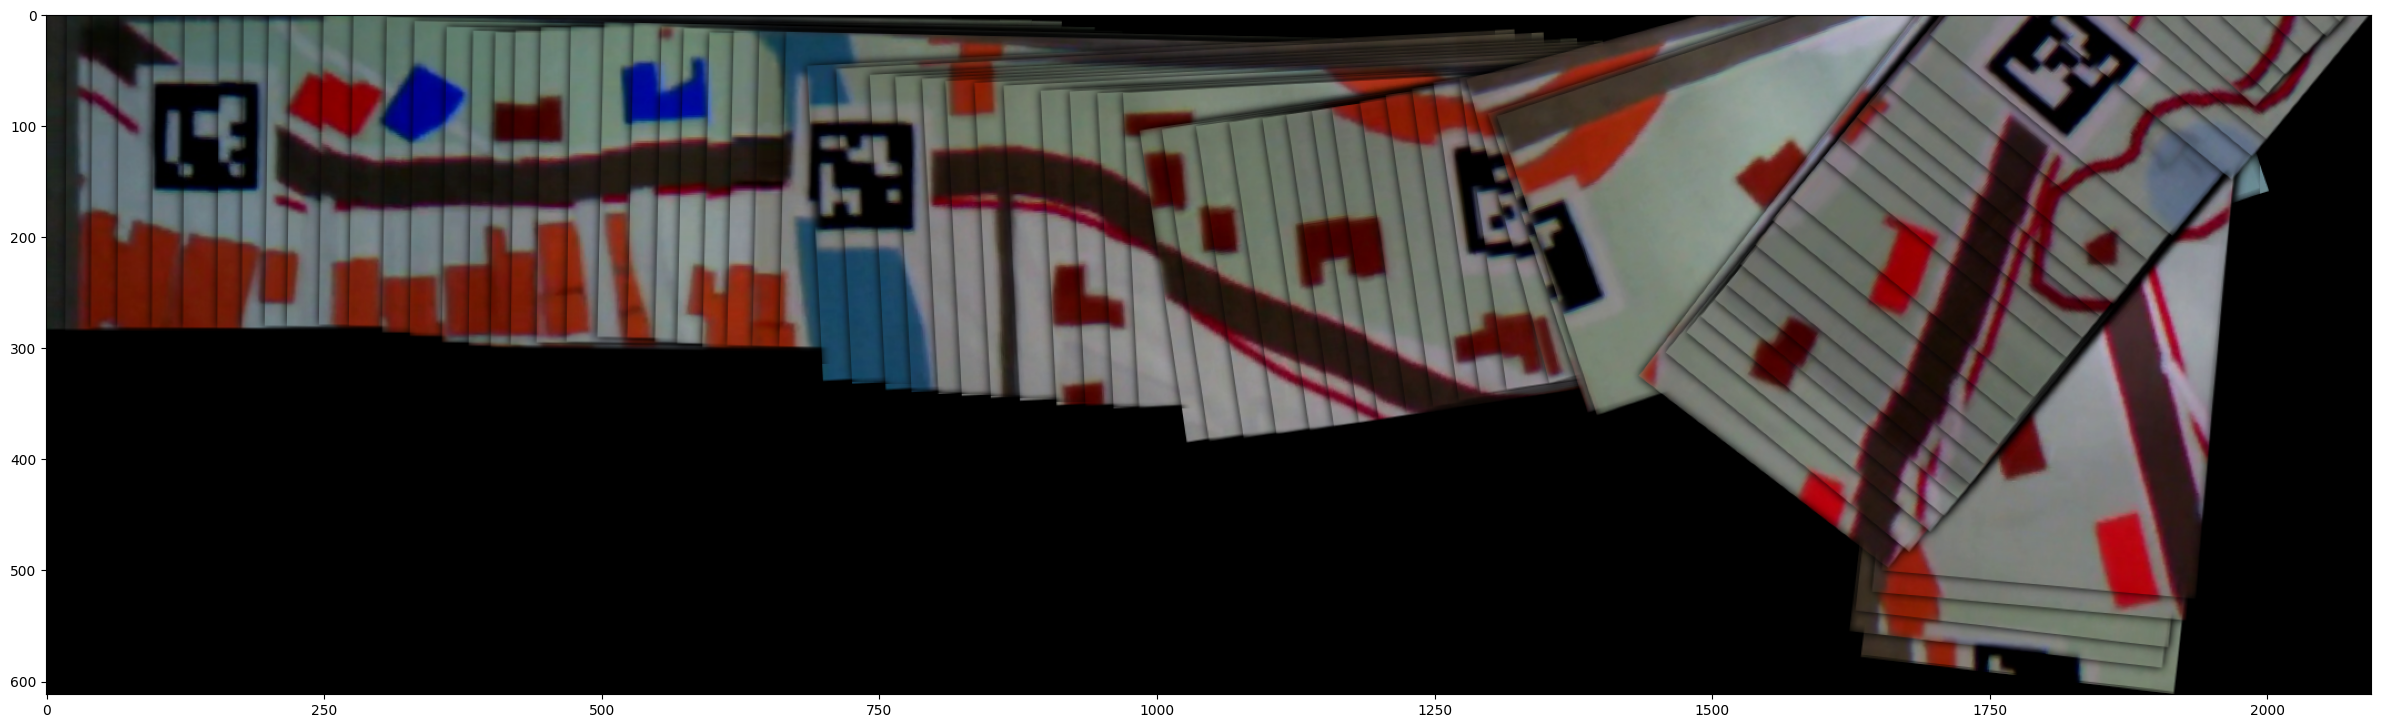

In [49]:
# ********* Penggabungan Citra Versi Sederhana *********
pref = imgs[0]
for i in range(1,n):
    left = pref
    left_gray = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    right_pp = np.ones_like(right_gray) * 255
    
    dim_x = left.shape[1] + right.shape[1]
    dim_y = left.shape[0] + right.shape[0]
    dim = (dim_x, dim_y)
    comb = cv2.warpPerspective(right, TM[i-1], dim)

    # ********* Membuat Mask *********
    th = cv2.warpPerspective(right_pp, TM[i-1], dim)
    kernel = np.ones((40, 40), np.uint8)
    mask = cv2.erode(th, kernel, iterations=1)
    mask = cv2.GaussianBlur(th, (25, 25), 0)

    # ********* Jahit Citra *********
    for k in range(left.shape[0]):
        for l in range(left.shape[1]):
            alpha = mask[k,l]/255
            comb[k,l] = (1-alpha)*left[k,l] + alpha*comb[k,l]
    
    # ********* Crop *********
    comb_gray = cv2.cvtColor(comb, cv2.COLOR_BGR2GRAY)
    for j in range(int(dim_x/2),dim_x):
        if comb_gray[:,j].sum() == 0:
            x_crop = j
            break
        else:
            x_crop = dim_x
    for j in range(int(dim_y/2),dim_y):
        if comb_gray[j,:].sum() == 0:
            y_crop = j
            break
        else:
            y_crop = dim_y
    if y_crop == dim_y or x_crop == dim_x:
        print("Penjahitan Error!")
        break
    pref = comb[:y_crop, :x_crop]
plot_images(pref)